In [1]:
import numpy as np
import pandas as pd
import ssl
import copy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import random
import pickle
from pprint import pprint
from imblearn.over_sampling import RandomOverSampler,SMOTE, ADASYN, SMOTENC, SVMSMOTE
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import hamming_loss, roc_auc_score
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import wordcloud
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_curve
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC, NuSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
import scikitplot as skplt
import matplotlib.pyplot as plt
from keras import optimizers
from keras.losses import binary_crossentropy
from keras.metrics import binary_accuracy
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from scipy.special import softmax
ssl._create_default_https_context = ssl._create_unverified_context

Using TensorFlow backend.


In [2]:
def clean_statement(statement):
    statement = re.sub('$', ' ', statement)
    statement = re.sub('[^A-Za-z]+', ' ', statement)
    statement = re.sub('[,|.|?|\n]|\t', '', statement)
    statement = re.sub('n\'t', ' ', statement)
    statement = re.sub('submission|submissions|Submission|submission|th ', '', statement)
    statement = re.sub('one|two|given|need', '', statement)
    return statement

In [3]:
def process_problem_statement(q_statement):
    q_statement = clean_statement(q_statement)
    tokens = word_tokenize(q_statement)
    stoplist = set(stopwords.words('english'))
    word_list = [i for i in q_statement.lower().split() if i not in stoplist]
    ps = PorterStemmer()
    q_statement = ' '.join(word_list)
    return q_statement

In [4]:
def process_problem_solution(solution):
    tokens = word_tokenize(solution)
    stoplist = set(stopwords.words('english'))  
    word_list = [i for i in solution.lower().split() if i not in stoplist]
    solution = ' '.join(word_list)
    return solution

In [5]:
def process_time_taken(time_col):
    return time_col.split()[0]

In [6]:
def process_tags(all_tags_list,tag_col):
    tags_present = list(re.split(',',tag_col))
    return tags_present

In [7]:
def get_all_distinct_tags(tags_col):
    
    tags_list = []
    
    t_sets = set(tags_list)
    
    for row in tags_col:
        t_list = re.split(',',row)
        t_sets = t_sets.union(set(t_list))
        
    tags_list = list(t_sets)
    
    stoplist = set(stopwords.words('english'))
    
    word_list = [i for i in tags_list if i not in stoplist]
    
    return tags_list

In [8]:
# tag list obtained from the dataset
# global tags_list
tags_list = ['dsu', 'trees', 'chinese remainder theorem', 'sortings', 'games', 'implementation', 'bitmasks',
              '*special', 'hashing', 'geometry', 'two pointers', 'combinatorics', 'flows', 'strings',
              'probabilities', 'data structures', 'ternary search', 'greedy', 'math', 'matrices',
              'divide and conquer', 'dfs and similar', 'constructive algorithms', 'brute force', 'dp',
              '2-sat', 'graph matchings', 'binary search', 'number theory', 'graphs', 'fft', 'shortest paths',
              'schedules', 'meet-in-the-middle', 'string suffix structures', 'expression parsing']

In [9]:
def plot_class_distribution(Y,classes):
    count_list = [0]*Y.shape[1]
    for index in range(Y.shape[1]):
        count_list[index] = np.sum(Y[:,index])/Y.shape[0]
    plt.figure(figsize=(8, 8), dpi=100)
    plt.barh(classes,count_list, align='center', alpha=0.5)
    plt.show()

In [10]:
def data_preprocessing():
    global X, Y, mlb, distinct_tags
    df = pd.read_csv("../Coding-Questions-Classifier/sample data/codeforces_question_v5.csv")
    print(df.shape)
    df = df.drop(['id','name','author'],axis = 1)
    df = df[df.solution != "no code found"]
    df = df.dropna()
    distinct_tags = get_all_distinct_tags(df["tags"])
    df["problem statement"] = [process_problem_statement(x) for x in df["problem statement"]]
    df["solution"] = [process_problem_solution(x) for x in df["solution"]]
    df["time_taken"] = [process_time_taken(x) for x in df["time_taken"]]
    X = copy.deepcopy(df["problem statement"])
    Y = [process_tags(distinct_tags,x) for x in df["tags"]]
    mlb = MultiLabelBinarizer()
    Y_ = mlb.fit_transform(Y) 
    plot_class_distribution(Y_,mlb.classes_)
    return df,Y_

(40138, 9)


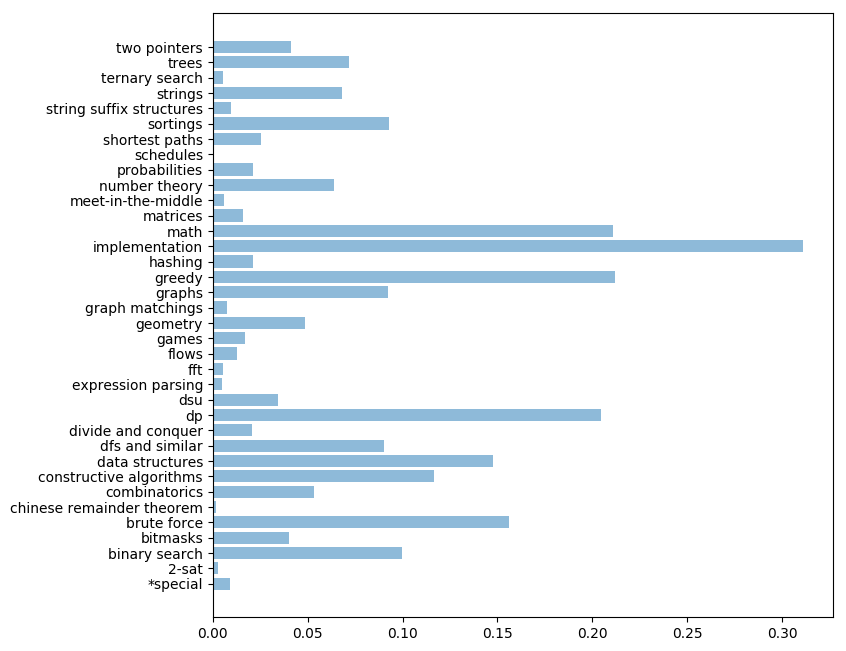

In [11]:
df,Y_ = data_preprocessing()

In [12]:
df = df[['problem statement', 'difficulty', 'sol id', 'solution','time_taken']]
df

,problem statement,difficulty,sol id,solution,time_taken
0,two integer sequences existed initially strict...,2600.0,52221361,#include <bits/stdc++.h> using namespace std; ...,280
1,two integer sequences existed initially strict...,2600.0,52205839,#include <bits/stdc++.h> using namespace std; ...,280
2,two integer sequences existed initially strict...,2600.0,52232606,#include<iostream> #include<cstdio> #include<a...,280
3,two integer sequences existed initially strict...,2600.0,52155590,/* name allah */ #include<bits/stdc++.h> using...,280
4,two integer sequences existed initially strict...,2600.0,52209306,#include <bits/stdc++.h> #define long long int...,296
5,two integer sequences existed initially strict...,2600.0,52367859,#include<bits/stdc++.h> using namespace std; i...,139
6,two integer sequences existed initially strict...,2600.0,52463041,#include<iostream> #include<algorithm> #includ...,78
7,two integer sequences existed initially strict...,2600.0,52147075,#include <iostream> using namespace std; int m...,280
8,two integer sequences existed initially strict...,2600.0,52296774,#include <cstdio> #include <algorithm> #includ...,311
9,two integer sequences existed initially strict...,2600.0,52339991,#include<bits/stdc++.h> using namespace std; c...,78


In [13]:
from sklearn.model_selection import train_test_split
y=Y_
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2)
print(type(X_train))
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(39788, 36)
<class 'pandas.core.frame.DataFrame'>
(31830, 5) (31830, 36)
(7958, 5) (7958, 36)


In [14]:
def reduce_sample_imbalance(X_train,Y_train):
    global X, Y, mlb, distinct_tags
    X_train = pd.DataFrame(X_train).values
    xtrain_col_index = X_train.shape[1]
    xtrain_row_index = X_train.shape[0]
    XY = np.column_stack((X_train,Y_train))
    labels = [0]*len(mlb.classes_)
    row_index_to_delete = []
    ratio = []
    
    for index in range(Y_train.shape[1]):
        ratio.append(np.sum(Y_train[:,index])/Y_train.shape[0])
        if np.sum(Y_train[:,index])/Y_train.shape[0] > 0.03:
            labels[index] = 1
            
    ratio.sort()
    count_deletions = [0]*len(labels)
    for index in range(len(labels)):
        if labels[index] == 1:
            count_deletions[index] = int(np.sum(Y_train[:,index]) * 0.97)    
    
    for index in range(Y_train.shape[0]):
        flag_to_delete = True
        for yindex in range(X_train.shape[1],XY.shape[1]):
            if Y_train[index][yindex-X_train.shape[1]] == 1:
                if labels[yindex-X_train.shape[1]] == 0 or count_deletions[yindex-X_train.shape[1]] <= 0:
                    flag_to_delete = False
                    break
        if flag_to_delete:
            row_index_to_delete.append(index)
            for i in range(len(count_deletions)):
                count_deletions[i] -= Y_train[index][i]
        if sum(count_deletions) <= 0:
            break;
            
    XY = np.delete(XY, row_index_to_delete,axis=0)
    ratio = []
    for index in range(X_train.shape[1],XY.shape[1]):
        ratio.append(np.sum(XY[:,index])/XY.shape[0])
    
    plot_class_distribution(XY[:,X_train.shape[1]:],mlb.classes_)
    data_to_repeat_index = [1]*XY.shape[0]
    labels = [0]*len(mlb.classes_)
    ratio = []
    for index in range(xtrain_col_index,XY.shape[1]):
        ratio.append(np.sum(XY[:,index])/XY.shape[0])
        if np.sum(XY[:,index])/XY.shape[0] < 0.02:
            labels[index-xtrain_col_index] = 1
    ratio.sort()
        
    for index in range(XY.shape[0]):
        for yindex in range(X_train.shape[1],XY.shape[1]):
            if XY[index][yindex] == 1 and labels[yindex-X_train.shape[1]] > 0:
                data_to_repeat_index[index] = 100
                labels[yindex-X_train.shape[1]] = -1
    
    XY = np.repeat(XY, repeats = data_to_repeat_index, axis=0)
    X_train = XY[:,0]
    Y_train = XY[:,1:]
    X_train = pd.Series(X_train)
#     X_train = X_train.astype(str)
#     Y_train = Y_train.astype('int') 
    return X_train,Y_train, XY

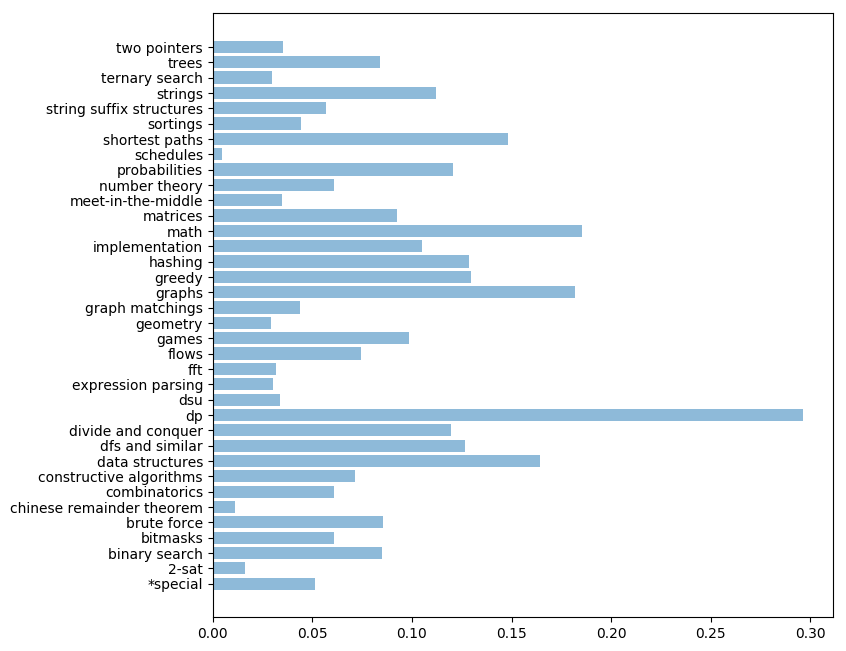

In [15]:
X_train_1,y_train_1,XY_1 = reduce_sample_imbalance(X_train,y_train)

In [17]:
print(X_train_1.shape, y_train_1.shape, XY_1.shape)

(5782,) (5782, 40) (5782, 41)


In [18]:
cols = []
for i in range(4,40):
    cols.append(i)

In [19]:
dataframe = pd.DataFrame.from_records(y_train_1)
dataframe['Tags'] = dataframe[cols].values.tolist()
dataframe = dataframe.drop(cols, axis=1)
# [,,,,'Tags']
dataframe.rename(columns={0:'Difficulty', 1:'Solution ID', 2:'Problem Statement', 3:'Time Taken'})

,Difficulty,Solution ID,Problem Statement,Time Taken,Tags
0,3400.0,50089524,"#include <bits/stdc++.h> #define for(i, j, k) ...",2339,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
1,3400.0,50089524,"#include <bits/stdc++.h> #define for(i, j, k) ...",2339,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
2,3400.0,50089524,"#include <bits/stdc++.h> #define for(i, j, k) ...",2339,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
3,3400.0,50089524,"#include <bits/stdc++.h> #define for(i, j, k) ...",2339,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
4,3400.0,50089524,"#include <bits/stdc++.h> #define for(i, j, k) ...",2339,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
5,3400.0,50089524,"#include <bits/stdc++.h> #define for(i, j, k) ...",2339,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
6,3400.0,50089524,"#include <bits/stdc++.h> #define for(i, j, k) ...",2339,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
7,3400.0,50089524,"#include <bits/stdc++.h> #define for(i, j, k) ...",2339,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
8,3400.0,50089524,"#include <bits/stdc++.h> #define for(i, j, k) ...",2339,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
9,3400.0,50089524,"#include <bits/stdc++.h> #define for(i, j, k) ...",2339,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."


In [20]:
def oversample_train_data(X_train,Y_train):
    global X, Y, mlb, distinct_tags
    X_train = pd.DataFrame(X_train).values
    XY = np.column_stack((X_train,Y_train))
    labels = []
    data_to_repeat_index = [1]*Y_train.shape[0]
    
    for index in range(Y_train.shape[1]):
        if np.sum(Y_train[:,index])/Y_train.shape[0] < 0.02:
            labels.append(index)
    
    for index in range(Y_train.shape[0]):
        for label in labels:
            if Y_train[index][label] == 1:
                data_to_repeat_index[index] = 200
                
    XY = np.repeat(XY, repeats = data_to_repeat_index, axis=0) 
    X_train = XY[:,0]
    Y_train = XY[:,1:]
    X_train = pd.Series(X_train)
#     X_train = X_train.astype(str)
#     Y_train = Y_train.astype('int') 
    return X_train,Y_train, XY

In [21]:
X_train_2,y_train_2,XY_2 = oversample_train_data(X_train,y_train)

In [22]:
print(X_train_2.shape,y_train_2.shape,XY_2.shape)

(634999,) (634999, 40) (634999, 41)


In [27]:
dataframe_oversampled = pd.DataFrame.from_records(y_train_2)
dataframe_oversampled['Tags'] = dataframe_oversampled[cols].values.tolist()
dataframe_oversampled = dataframe_oversampled.drop(cols, axis=1)
dataframe_oversampled.rename(columns={0:'Difficulty', 1:'Solution ID', 2:'Problem Statement', 3:'Time Taken'})

,Difficulty,Solution ID,Problem Statement,Time Taken,Tags
0,2100.0,45071164,#include <iostream> #include <algorithm> #incl...,372,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ..."
1,2500.0,41324531,#include <bits/stdc++.h> #define max #define x...,998,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,1200.0,40389914,#include<bits/stdc++.h> using namespace std; i...,31,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,1400.0,29831860,#include<bits/stdc++.h> const int n = 2525; us...,109,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,2400.0,49845066,#include<bits/stdc++.h> using namespace std; c...,466,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
5,1200.0,27796610,#include<bits/stdc++.h> using namespace std; i...,15,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,1600.0,42499274,#include<bits/stdc++.h> using namespace std; m...,404,"[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
7,3400.0,50089524,"#include <bits/stdc++.h> #define for(i, j, k) ...",2339,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
8,3400.0,50089524,"#include <bits/stdc++.h> #define for(i, j, k) ...",2339,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
9,3400.0,50089524,"#include <bits/stdc++.h> #define for(i, j, k) ...",2339,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
